## Introduction

I’ve been thinking about writing a new blog post for a while now but honestly, there was nothing coming to my mind that made me think "Oh, yeah, this is interesting, it can be useful for someone else". And it was just a few hours ago that I realized I could write about something quite curious that happened to me while trying to replicate a Bambi model with PyMC3.

[PyMC3](https://docs.pymc.io/) is a Python package for Bayesian statistical modeling that implements advanced Markov chain Monte Carlo algorithms, such as the No-U-Turn sampler (NUTS). [Bambi](https://bambinos.github.io/bambi/) is a high-level Bayesian model-building interface in Python. It is built on top of PyMC3 and allows users to specify and fit Generalized Linear Models (GLMs) and Generalized Linear Mixed Models (GLMMs) very easily using a model formula much similar to the popular model formulas in R.

A couple of weeks ago [Agustina Arroyuelo](https://twitter.com/AgustinaArroyu1) told me she was trying to replicate a [model](https://bambinos.github.io/bambi/master/notebooks/wald_gamma_glm.html#Wald) in one of the example notebooks we have  in Bambi and wanted my opinion on what she was doing. After many attempts, neither of us could replicate the model successfully. It turned out to be we were messing up with the shapes of the priors and also had some troubles with the design matrix.

The point of this post is not about good practices when doing Bayesian modeling neither about modeling techniques. This post aims to show how Bambi can save you effort, code, and prevent us from making some mistakes when fitting not-so-trivial GLMs in Python. 

Well, I think this is quite enough for an introduction. Let's better have a look at the problem at hand.

In [37]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt

## The problem

In this problem we use a data set consisting of 67856 insurance policies and 4624 (6.8%) claims in Australia between 2004 and 2005. 
The original source of this dataset is the book [Generalized Linear Models for Insurance Data](http://www.businessandeconomics.mq.edu.au/our_departments/Applied_Finance_and_Actuarial_Studies/research/books/GLMsforInsuranceData) by Piet de Jong and Gillian Z. Heller.

In [2]:
url = "https://courses.ms.ut.ee/2020/glm/spring/uploads/Main/carclaims.csv"
data = pd.read_csv(url)
data = data[data["claimcst0"] > 0]

The age (binned), the gender, and the area of residence are used to predict the amount of the claim, conditional on the existence of the claim because we are only working with observations where there is a claim.

We use a Wald regression model. This is a GLM where the random component follows a [Wald distribution](https://en.wikipedia.org/wiki/Inverse_Gaussian_distribution). The link function we choose is the natural logarithm.

## PyMC3 model

### Data preparation

To fit the model with PyMC3 we first need to create the model matrix. We need to represent `age`, `area`, and `gender` with dummy variables because they are categorical. We can think of the following objects as sub-matrices of the design matrix in the model.

In [3]:
intercept = np.ones((len(data), 1))
age = pd.get_dummies(data["agecat"], drop_first=True).to_numpy()
area = pd.get_dummies(data["area"], drop_first=True).to_numpy()
gender = pd.get_dummies(data["gender"], drop_first=True).to_numpy()

Note we have used `drop_first=True`. This means that we use `n_levels - 1` dummies to represent each categorical variable, and the first level is taken as reference. This ensures the resulting design matrix is of full rank.

Next, we stack these sub-matrices horizontally and convert the result to a Theano tensor variable so we can compute the dot product between this matrix and the vector of coefficients when writing our model in PyMC3.

In [4]:
X = np.hstack([intercept, age, gender, area])
X = tt.as_tensor_variable(X)

### Fit

We start declaring the priors for each of the predictors in the model. They are all independent Gaussian distributions. You may wonder where I took the values for the parameters of these distributions. I've just copied Bambi's default values for this particular problem.

At this stage, it is **very important** to give appropriate shapes to all the objects we create in the model. For example, `β_age` is a random variable that represents the coefficients for the age variable. Since 5 dummy variables are used to represent the age, both `β_age` and the values passed to `mu` and `sigma` must have `shape=(5, 1)`. 
[I've failed here many times](https://discourse.pymc.io/t/create-model-matrix/7429) when trying to replicate the model, so, unfortunately, I know what I'm talking about 😅

In [31]:
# Create model and sample posterior
with pm.Model() as model_pymc3:
    # Build predictors
    β_0 = pm.Normal("β_0", mu=0, sigma=5, shape=1)
    β_gender = pm.Normal("β_gender", mu=0, sigma=5, shape=1)
    β_age = pm.Normal(
        "β_age",
        mu=np.array([0] * 5),
        sigma=np.array([0.32, 6.94, 1.13, 5.44, 9.01]),
        shape=5
    )
    β_area = pm.Normal(
      "β_area",
      mu=np.array([0] * 5),
      sigma=np.array([0.86, 0.25, 1.3, 0.76, 5.33]),
      shape=5
    )
    
    # Concatenate the vectors for the coefficients into a single vector
    β = tt.concatenate([β_0, β_age, β_gender, β_area], axis=0)
    
    # Compute and transform linear predictor
    mu = tt.exp(X.dot(β))
      
    lam = pm.HalfCauchy("claim_lam", beta=1)
    pm.Wald("claim", mu=mu, lam=lam, observed=data["claimcst0"])
    
    idata_pymc = pm.sample( 
      draws=2000, 
      target_accept=0.9, 
      random_seed=1234,
      return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [claim_lam, β_area, β_gender, β_age, β_0]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 26 seconds.


## Bambi model

As you can see below, we don't need to do any data preparation, or even specify priors by hand. Bambi automatically obtains sensible default priors when they are not specified, and also knows how to handle each variable type very well. 

The model is specified using a model formula, quite similar to model formulas in R. The left-hand side of `~` is the response variable, and the rest are the predictors. Here `C(agecat)` tells Bambi that `agecat` should be interpreted as categorical. The `family` argument indicates the conditional distribution for the response, and the `link` tells Bambi which function of the mean is being modeled by the linear predictor. More information about how they work can be found [here](https://bambinos.github.io/bambi/master/notebooks/getting_started.html#Families).

Then we have the `.fit()` method, where you can pass arguments to the `pm.sample()` function that's running in the background.

In [7]:
model_bambi = bmb.Model(
  "claimcst0 ~ C(agecat) + gender + area", 
  data, 
  family = "wald", 
  link = "log"
)
idata_bambi = model_bambi.fit(draws=2000, target_accept=0.9, random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [claimcst0_lam, area, gender, C(agecat), Intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 19 seconds.


And that's it! A model that took several lines of codes to specify in PyMC3 only took a few lines of code in Bambi. Quite an advantage, right?

## Check results

The simplicity we gain with Bambi would be worthless if the results turned out to be different. We want an interface that makes our job easier, without affecting the quality of the inference. The following is a forest plot where the point gives the posterior mean and the bars indicate a 94% HDI.

In [40]:
summary_pymc = az.summary(idata_pymc)
summary_bambi = az.summary(idata_bambi)

In [41]:
summary_pymc["row"] = list(range(13))
summary_pymc["panel"] = ["1-Intercept"] + ["2-Effects"] * 11 + ["3-Dispersion"]

summary_bambi["row"] = list(range(13))
summary_bambi["panel"] = ["1-Intercept"] + ["2-Effects"] * 11 + ["3-Dispersion"]

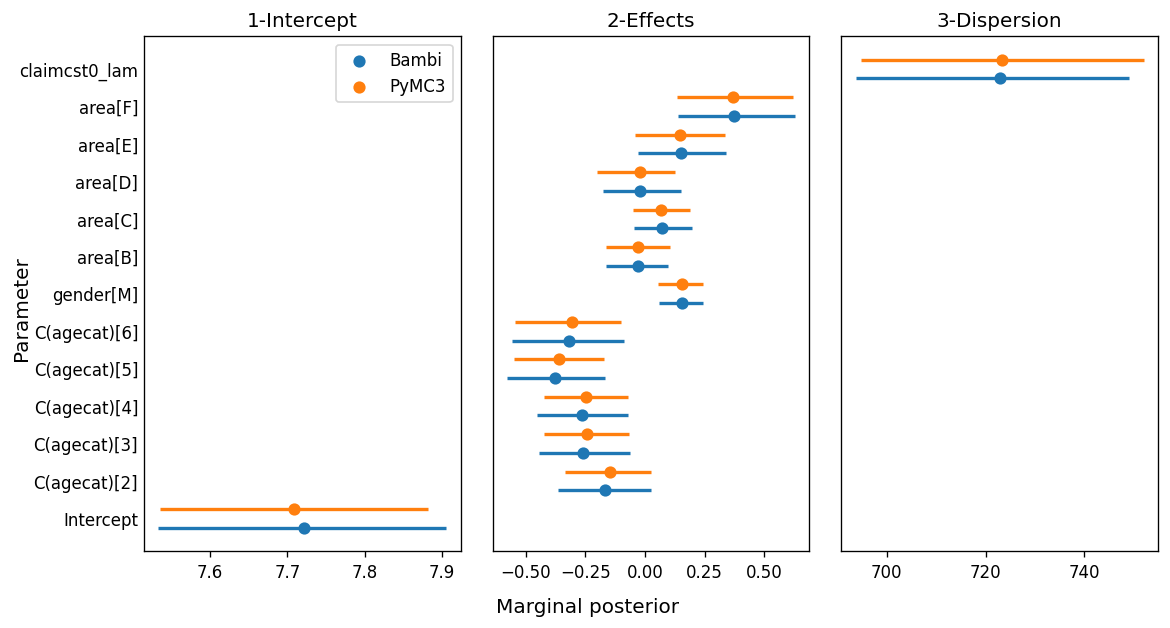

In [70]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5.33), sharey=True, dpi=120)
fig.subplots_adjust(left=0.13, right=0.975, wspace=0.1, bottom=0.12, top=0.925)
fig.set_facecolor("w")

for i, (ax, panel) in enumerate(zip(axes, ["1-Intercept", "2-Effects", "3-Dispersion"])):
    plt_data = summary_bambi[summary_bambi["panel"] == panel]
    ax.scatter(plt_data["mean"], plt_data["row"] - 0.25, s=40, label="Bambi")
    ax.hlines(plt_data["row"] - 0.25, plt_data["hdi_3%"], plt_data["hdi_97%"], lw=2)
    
    plt_data = summary_pymc[summary_pymc["panel"] == panel]
    ax.scatter(plt_data["mean"], plt_data["row"] + 0.25, s=40, label="PyMC3")
    ax.hlines(plt_data["row"] + 0.25, plt_data["hdi_3%"], plt_data["hdi_97%"], lw=2, color="C1")
    
    ax.set_title(panel)
    ax.tick_params("y", length=0)

axes[0].legend()
ax.set_yticks(range(len(summary_bambi.index)))
ax.set_yticklabels(list(summary_bambi.index))

fig.text(0.5, 0.025, "Marginal posterior", size=12, ha="center")
fig.text(0.02, 0.5, "Parameter", size=12, va="center", rotation=90)

fig.savefig("imgs/plot.png", dpi=120)

While most of the marginal posteriors match very well, we can clearly see the ones for `β_area[3]` and `β_area[4]` don't overlap as much as the others. One of the possible explanations for this difference is related to the MCMC algorithm. While we know both models are indeed the same model, their internal representation is not exactly the same. For example, the model we wrote in pure PyMC3 computes a unique dot product between a matrix of shape `(n, p)` a vector of shape `(p, 1)`, while the model in Bambi is computing the sum of many smaller dot products. As the internal representations are not exactly the same, the sampling spaces differ and the sampling algorithm obtained slightly different results.

## Conclusion

In this post, we saw how the same GLM can be expressed in both PyMC3 and Bambi. PyMC3 allowed us to control every fine-grained detail of the model specification, while Bambi allowed us to express the same model in a much more concise manner.

Bambi's advantages in these types of scenarios aren't only related to the amount of code one has to write. Bambi also prevents us from making mistakes when writing the PyMC3 model, such as the mistakes I was making when specifying the shapes for the distributions. Or one could just simply don't know how correctly prepare  the data that should go in the design matrix, such as the conversion of the categorical data to numeric matrices in such a way that the information is retained without introducing structural redundancies.

Nevertheless, this doesn't mean we should always favor Bambi over PyMC3. Whether Bambi or PyMC3 is appropriate for you actually depends on your use case. If you're someone who mainly needs to fit GLMs or GLMMs, Bambi is the way to go and it would be nice you give it a chance. There are a [bunch of examples](https://bambinos.github.io/bambi/main/examples.html) showing how to specify and fit different GLMs with Bambi. On the other hand, if you're someone who writes a lot of custom models, PyMC3 will be your best friend when it comes to working with Bayesian models in Python.

Bambi is a community project and welcomes contributions such as bug fixes, examples, issues related to bugs or desired enhancements, etc. Want to know more? Visit the [official docs](https://bambinos.github.io/bambi/main/index.html) or explore the [Github repo](https://github.com/bambinos/bambi). Also, if you have any doubts about whether the feature you want is available or going to be developed, feel free to reach out to us! You can always open a new issue to request a feature or leave feedback about the library, and we welcome them a lot 😁.

## Acknowledgments

I want to thank [Agustina](https://twitter.com/AgustinaArroyu1), [Ravin](https://twitter.com/canyon289), and [Osvaldo](https://twitter.com/aloctavodia) for very useful comments and feedback on an earlier version of this post. They helped me to make this post much nicer than what it was originally.